In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
import glob as gb
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare data and model

In [ ]:
# Fetch dataset
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_2000-present_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_1900-2000_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_test_3D_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_3D_human_train_portraits.zip > /dev/null
!unzip /content/drive/MyDrive/machine_learning/datasets/2D_3D_portraits.zip > /dev/null

In [ ]:
# Fetch model
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/001.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/003.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/003_new.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/004.zip > /dev/null

#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet18/000.zip -d 3D > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet18/015.zip -d 2D > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet18/010.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet18/011.zip > /dev/null

#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/003.zip > /dev/null
!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet101/003_new.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet18/030.zip -d R18> /dev/null
#!unzip /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet50/003.zip -d R50 > /dev/null

In [ ]:
DATASET_PATH = "2D_3D_portraits/2D" #"disney_test_3D_portraits"
DST_PATH = "test"

In [ ]:
# Optionally create a separate folder with the images to be tested
for i in ['human', 'humanoid', 'animal', 'machine', 'all']:
  for j in ['male', 'female']:
    dir = f'{DST_PATH}/{i}/{j}'
    # delete folder contents if already exist
    if os.path.exists(dir):
      shutil.rmtree(dir)
    os.makedirs(dir)

for d in ["test"]:
  for char_style in ['human', 'humanoid', 'animal', 'machine']:
    females = [os.path.abspath(f) for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [os.path.abspath(f) for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/male/*.jpg"))]
    # females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{char_style}/female/*.jpg"))]
    # males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{char_style}/male/*.jpg"))]

    # Randomly shuffle all images and select equal number of faces
    import random
    random.seed(0)
    random.shuffle(females)
    random.shuffle(males)

    if len(females) < len(males):
      males_subset = random.sample(males, len(females))
      males = males_subset
    else:
      females_subset = random.sample(females, len(males))
      females = females_subset

    # Copy files into destination folders
    for gender, gender_list in {'female':females, 'male':males}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.copyfile(full_fname, f"{DST_PATH}/{char_style}/{gender}/{fname}")
        shutil.copyfile(full_fname, f"{DST_PATH}/all/{gender}/{fname}")

In [ ]:
# Set path
data_dir = 'test'

# Gender distribution per character style
N = 0  # total files
gender_dist = {}
for dirpath, dirnames, filenames in os.walk(data_dir): 
    N_c = len(filenames)
    N += N_c
    #print("Files in ", dirpath, dirnames, N_c)

    if not dirnames: # list is empty so have full string and num files
      char_style = dirpath.split("/")[-2]
      label = dirpath.split("/")[-1]
      gender_dist[f"{char_style}_{label}"]= N_c

print("Total Files ", N)
print(gender_dist)

Total Files  3196
{'machine_male': 5, 'machine_female': 5, 'all_male': 799, 'all_female': 799, 'human_male': 334, 'human_female': 334, 'humanoid_male': 205, 'humanoid_female': 205, 'animal_male': 255, 'animal_female': 255}


In [ ]:
# Data transforms for testing
data_transforms = { 
    'test': transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # normalization is necessary for evaluation, because otherwise the model sees unexpecetd pixel colours
        transforms.Normalize([0.485, 0.456, 0.406], #ImageNet Mean
        [0.229, 0.224, 0.225]) #ImageNet StdDev
    ])
}

In [ ]:
# Create the dataloader
char_styles = ["human", "humanoid", "animal", "all", "machine"] # machine needs to be removed if empty folder so that no error

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms['test']) for x in char_styles} 
image_datasets = {x: datasets.ImageFolder(f"{data_dir}/{x}", data_transforms['test']) for x in char_styles} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in char_styles} 

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in char_styles} 
print("Dataset sizes:", dataset_sizes)

# Class names
class_names = image_datasets[char_styles[0]].classes 
# class_names = ["background", "female", "male"] # if there is a bg class
print("Dataset classes:", class_names)

Dataset sizes: {'human': 668, 'humanoid': 410, 'animal': 510, 'all': 1598, 'machine': 10}
Dataset classes: ['female', 'male']


In [ ]:
# Load model
model_name = 'model_best.pt' # 'RES18_FeatureExtractor_FineTuned_Disney_Checkpoint11_model.pth'
path_to_model = f'/content/output/{model_name}' # f'/content/drive/MyDrive/machine_learning/Code/Face_Gender_Classifier/{model_name}'
# model = models.resnet18(pretrained=True) # resnet18 or resnet50
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, len(class_names)) # binary classification: len(class_names) == 2, 3 if with background #, bias=False
# model.load_state_dict(torch.load(path_to_model, map_location=device))
model = torch.load(path_to_model)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Run inference and visualise results

In [ ]:
char_styles = ["human", "humanoid", "animal", "all", "machine"] # sometimes need to remove machine (if empty folder to prevent error)

In [ ]:
from torch.cuda.memory import reset_accumulated_memory_stats
import torch.nn.functional as F
import pandas as pd

def evaluate_model(model, criterion):
    since = time.time()
    best_acc = 0.0
    result = {}

    model.eval()   # Set model to evaluate mode
    df = pd.DataFrame(columns=["label", "prediction", "confidence_score"]) # to compare label to pred, and the confidence of model in order to better evaluate misclassification

    # Iterate over data.
    for x in char_styles: 
      running_loss = 0.0
      running_corrects = 0
      correct_females = 0
      correct_males = 0

      for inputs, labels in dataloaders[x]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # forward
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          conf, prediction = torch.max(F.softmax(outputs, dim=1), dim=1)
          temp1 = labels.cpu().data.numpy()
          temp2 = prediction.cpu().data.numpy()
          temp3 = conf.cpu().data.numpy()
          temp_df = pd.DataFrame({"label": temp1, "prediction": temp2, "confidence_score": temp3}) # temp1+1 if there is bg class
          df = pd.concat([df, temp_df])

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          for i, pred in enumerate(preds):
            if labels[i] == 0 and labels[i] == pred: # labels[i]+1 because there is bg class
              correct_females += 1
            if labels[i] == 1 and labels[i] == pred: # labels[i]+1 because there is bg class
              correct_males += 1

      epoch_loss = running_loss / dataset_sizes[x]
      epoch_acc = running_corrects.double().item() / dataset_sizes[x]
      female_acc = correct_females / gender_dist[f"{x}_female"]
      male_acc = correct_males / gender_dist[f"{x}_male"]
      result['test'+'_loss'] = epoch_loss
      result['test'+'_acc'] = epoch_acc
      result['test_female_acc'] = female_acc
      result['test_male_acc'] = male_acc
      print(f'Character style: {x}')
      print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      print(f'Female Acc: {correct_females}/{gender_dist[f"{x}_female"]} Male Acc: {correct_males}/{gender_dist[f"{x}_male"]}')
      print(f'Female Acc: {female_acc:.4f} Male Acc: {male_acc:.4f}')
      time_elapsed = time.time() - since
      print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
      print('\n')

    return result, df

criterion = nn.CrossEntropyLoss()
result, df = evaluate_model(model, criterion)

In [ ]:
# show label, pred and confidence of model when pred was made
df

label prediction  confidence_score
0      0          0          0.986371
1      0          1          0.526005
2      1          1          0.794368
3      1          1          0.966078
4      1          0          0.760006
..   ...        ...               ...
5      1          1          0.971242
6      0          1          0.618094
7      1          0          0.630932
8      0          1          0.787119
9      1          0          0.884189

[1710 rows x 3 columns]

In [ ]:
def visualize_model(model, num_images=6):
    #was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(18,18*2)) # Adjust to make images close together
    with torch.no_grad():
      for x in char_styles:
        for i, (inputs, labels) in enumerate(dataloaders[x]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 4, images_so_far)
                ax.axis('off')

                label = class_names[labels[j]] #labels[j]+1 if bg class
                pred = class_names[preds[j]]
                c = 'g' if label == pred else 'r'
                ax.set_title(f'Animation Style: {x},\n    Predicted: {pred},\n    Label: {label}', color=c)
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean # denormalise image
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    #model.train(mode=was_training)
                    fig.tight_layout()
                    return
                
                if images_so_far == 4 or images_so_far == 8 or images_so_far == 12:
                    break
            if images_so_far == 4 or images_so_far == 8 or images_so_far == 12:
                    break

        #model.train(mode=was_training) # What's all this model training stuff for?

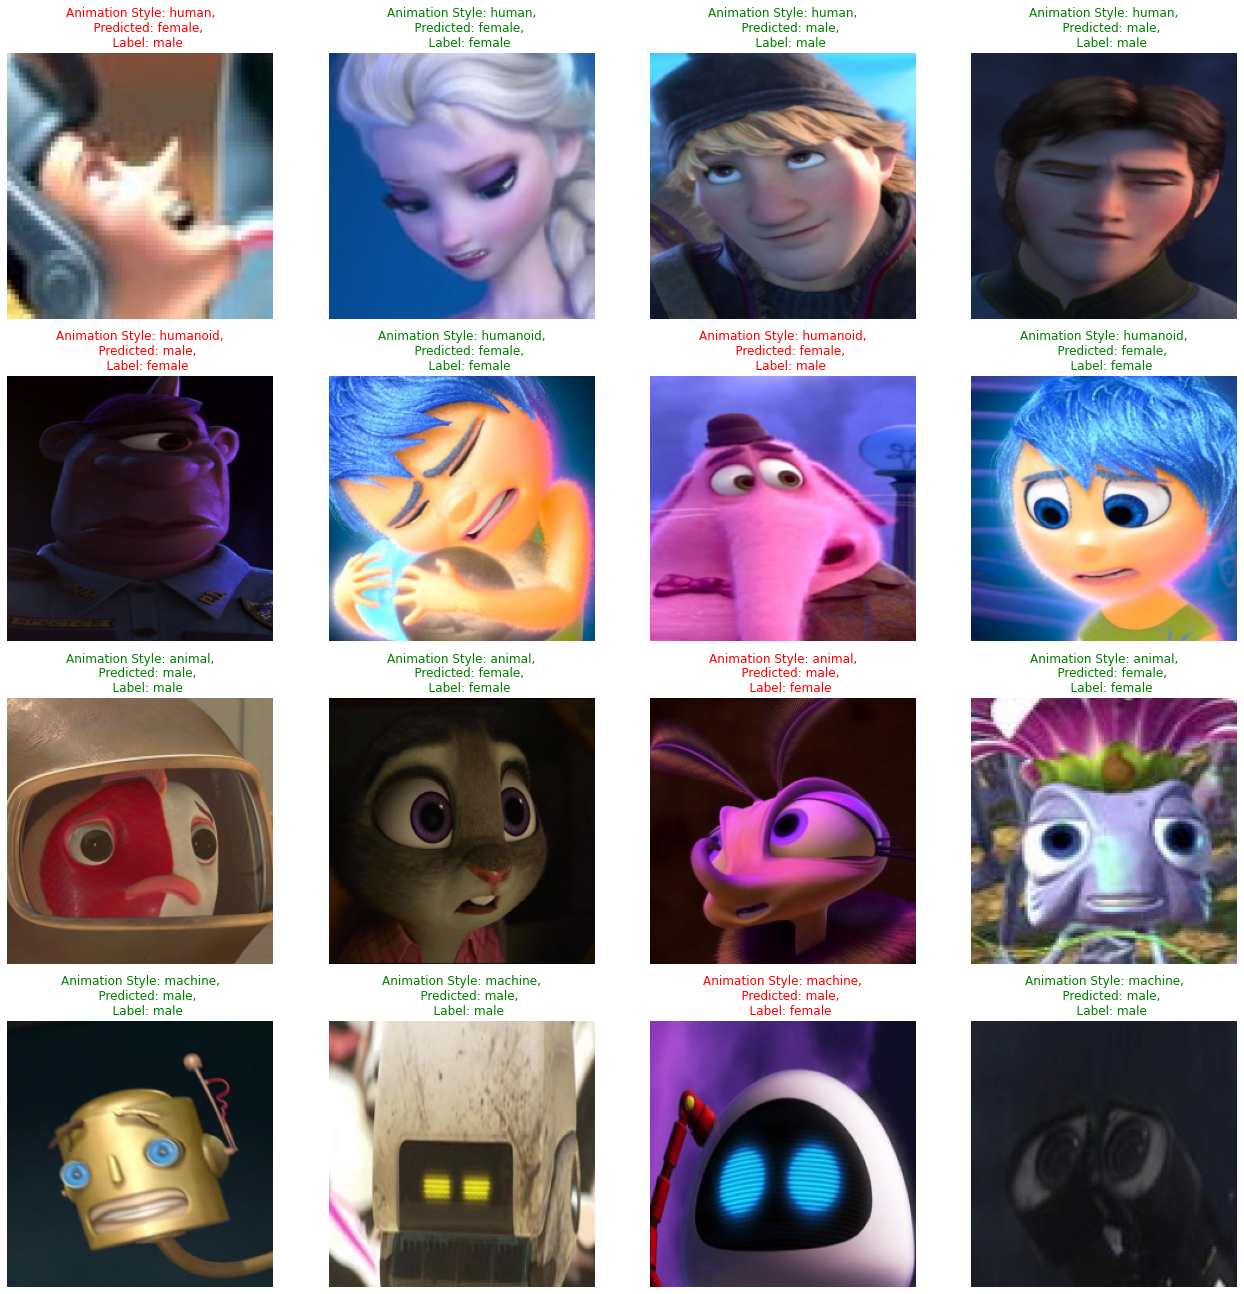

In [ ]:
visualize_model(model, num_images=16)
plt.savefig(data_dir+'_predictions.png')

### Visualize Grad Cam

In [ ]:
!pip install grad-cam > /dev/null

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import glob
import os

# Construct the CAM object once, and then re-use it on many images:
target_layers = [model.layer4[-1]] # for resnet18, resnet50
cam = GradCAM(model=model, target_layers=target_layers)
char_styles = ["human", "humanoid", "animal", "machine"] 

In [ ]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(18,18*4)) # Adjust to make images close together
    for x in char_styles:
      for i, (inputs, labels) in enumerate(dataloaders[x]):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          for j in range(inputs.size()[0]):
              images_so_far += 1
              ax = plt.subplot(num_images//2, 4, images_so_far)
              ax.axis('off')

              label = class_names[labels[j]]
              pred = class_names[preds[j]]
              c = 'g' if label == pred else 'r'
              ax.set_title(f'Animation Style: {x},\n    Predicted: {pred},\n    Label: {label}', color=c)

              inp = inputs.cpu().data[j]
              inp_np = inp.numpy().transpose((1, 2, 0))
              mean = np.array([0.485, 0.456, 0.406])
              std = np.array([0.229, 0.224, 0.225])
              inp_np = std * inp_np + mean # denormalise image
              inp_float_np = np.clip(inp_np, 0, 1)
              ax.imshow(inp_float_np)

              images_so_far += 1
              ax = plt.subplot(num_images//2, 4, images_so_far)
              ax.axis('off')

              input_tensor = inp.to(device)
              input_tensor = input_tensor.unsqueeze(0)
              grayscale_cam = cam(input_tensor)
              grayscale_cam = grayscale_cam[0, :]
              cam_image = show_cam_on_image(inp_float_np, grayscale_cam, use_rgb=True)
              act_map = Image.fromarray(cam_image)
              ax.imshow(act_map)

              if images_so_far == num_images:
                  fig.tight_layout()
                  return
              
              if images_so_far == 8 or images_so_far == 16 or images_so_far == 24:
                  break
          if images_so_far == 8 or images_so_far == 16 or images_so_far == 24:
                  break

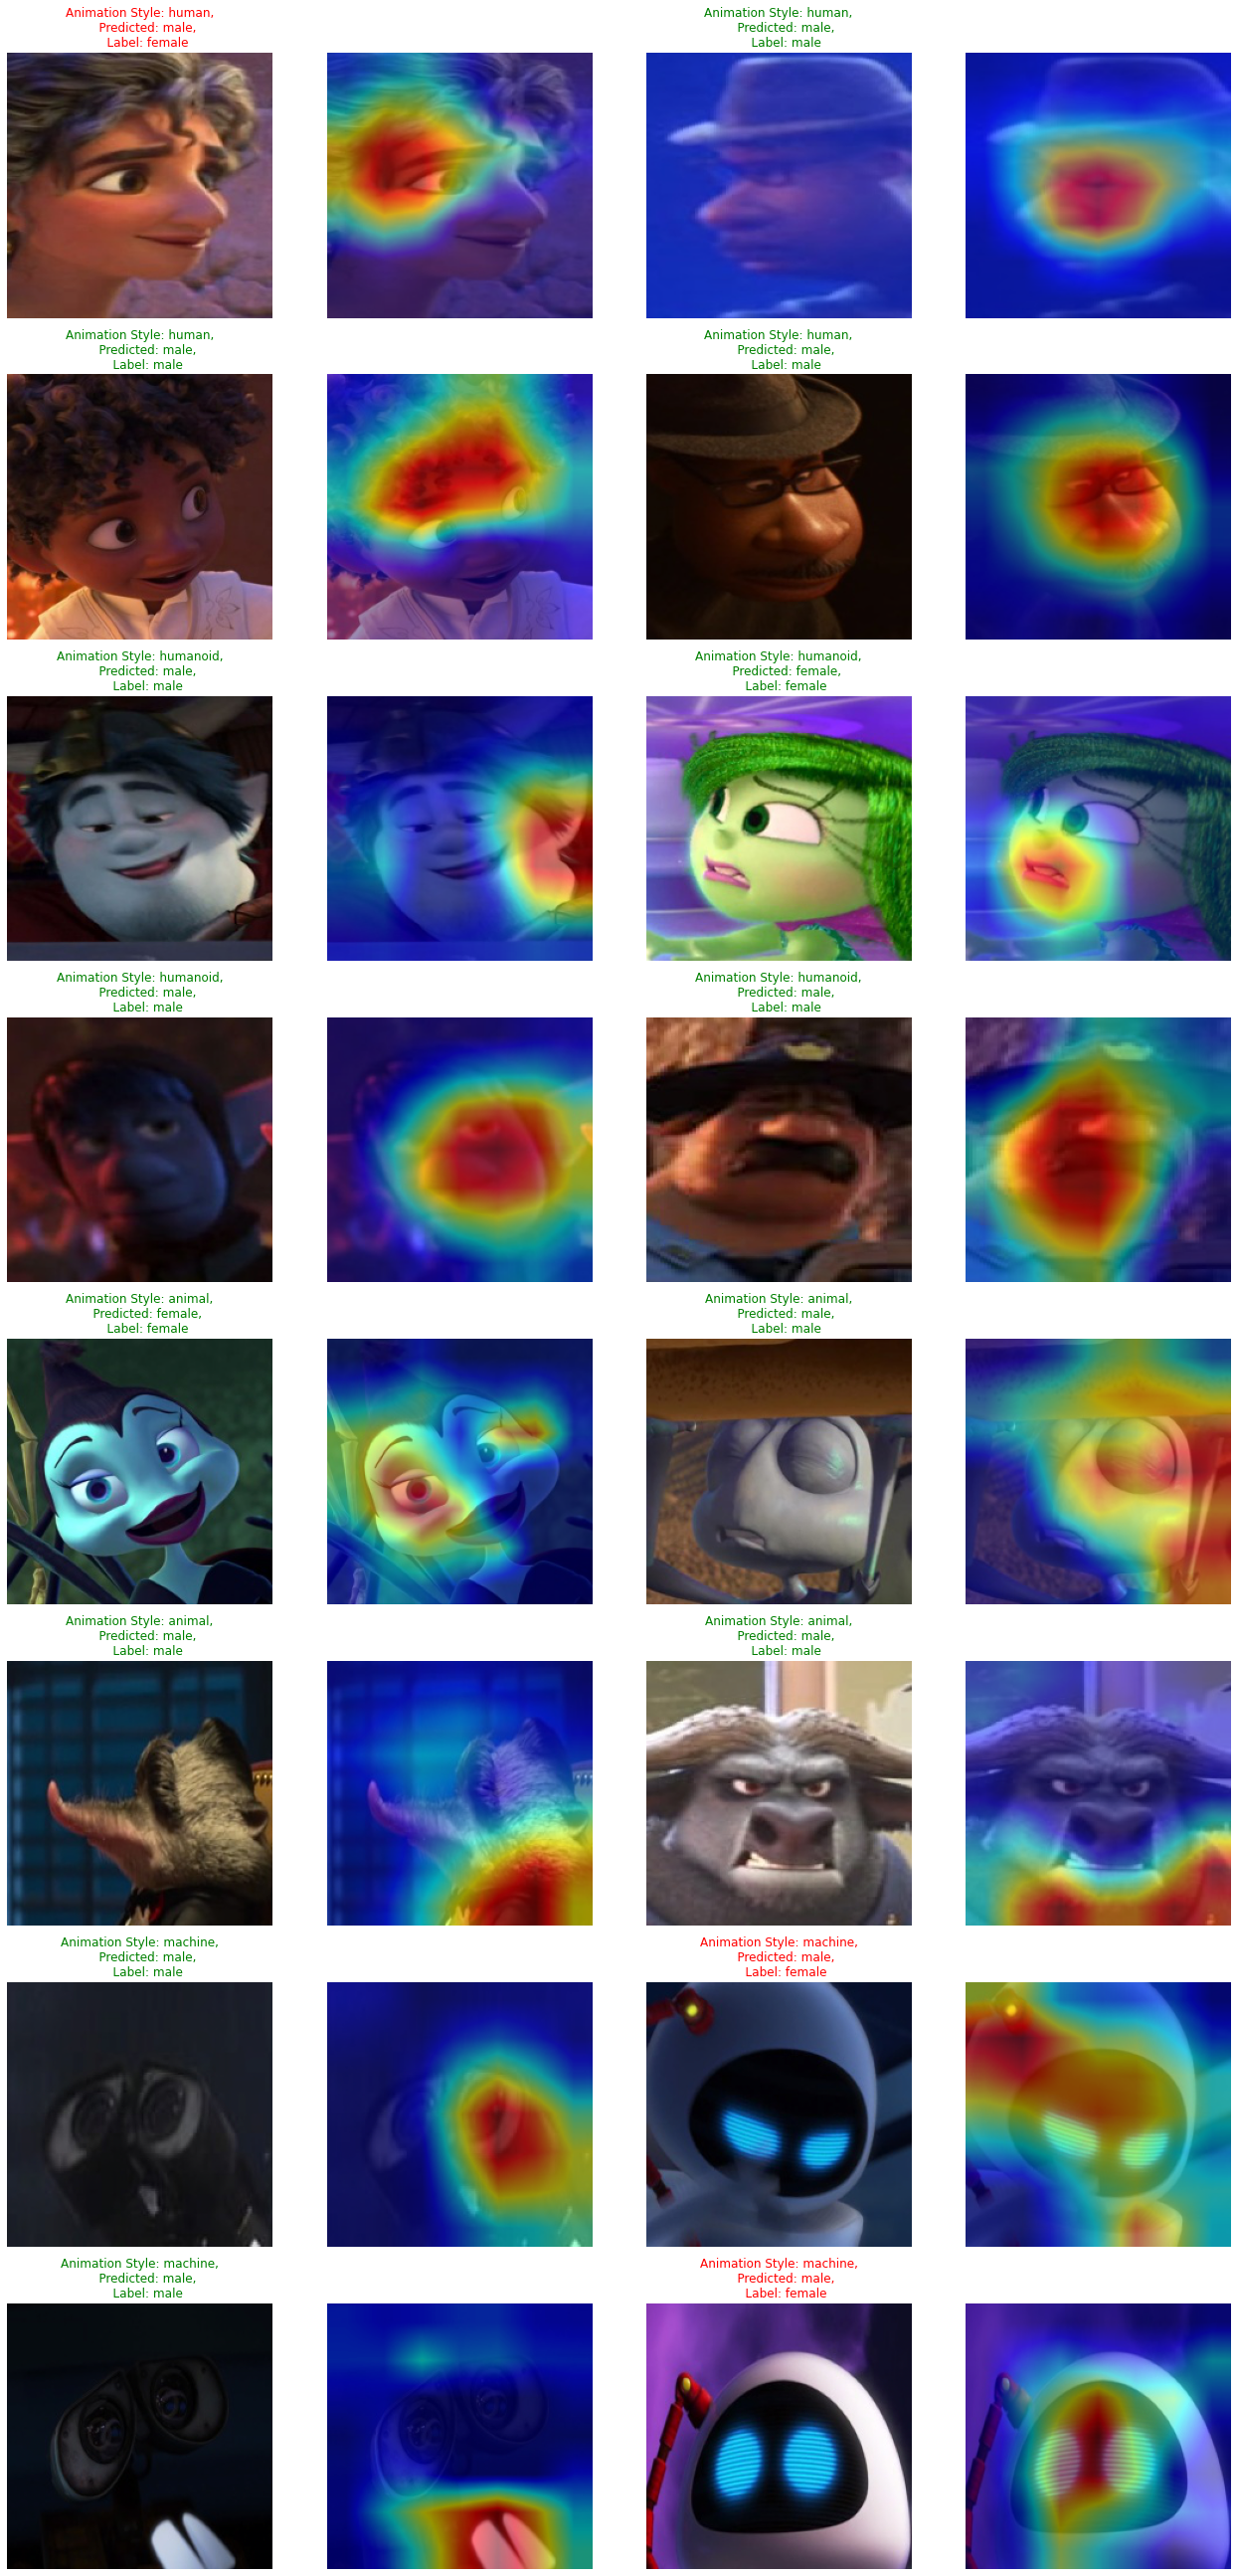

In [ ]:
visualize_model(model, num_images=32)
plt.savefig(data_dir+'_gradcam.png')

In [ ]:
# def visualize_model(model, num_images=16):
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure(figsize=(18,18*2)) # Adjust to make images close together
#     for i, (inputs, labels) in enumerate(dataloaders['val']): # can't use grad_cam_dataloader['grad_cam'] because doesnn't use normalization
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)

#         for j in range(inputs.size()[0]):
#             images_so_far += 1
#             ax = plt.subplot(num_images//2, 4, images_so_far)
#             ax.axis('off')

#             label = class_names[labels[j]]
#             pred = class_names[preds[j]]
#             c = 'g' if label == pred else 'r'
#             ax.set_title(f'Predicted: {pred},\n     Label: {label}', color=c)

#             inp = inputs.cpu().data[j]
#             inp_np = inp.numpy().transpose((1, 2, 0))
#             mean = np.array([0.485, 0.456, 0.406])
#             std = np.array([0.229, 0.224, 0.225])
#             inp_np = std * inp_np + mean # denormalise image
#             inp_float_np = np.clip(inp_np, 0, 1)
#             ax.imshow(inp_float_np)

#             images_so_far += 1
#             ax = plt.subplot(num_images//2, 4, images_so_far)
#             ax.axis('off')

#             input_tensor = inp.to(device)
#             input_tensor = input_tensor.unsqueeze(0)
#             grayscale_cam = cam(input_tensor)
#             grayscale_cam = grayscale_cam[0, :]
#             cam_image = show_cam_on_image(inp_float_np, grayscale_cam, use_rgb=True)
#             act_map = Image.fromarray(cam_image)
#             ax.imshow(act_map)

#             if images_so_far == num_images:
#                 fig.tight_layout()
#                 return

# visualize_model(model, num_images=16)
# plt.savefig(data_dir+'_gradcam.png')

# Save Cropped Detections? Not sure that this was originally for...

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import torchvision
# from torchvision import datasets, models, transforms
# from torchsummary import summary

# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import shutil
# import pandas as pd
# import glob as gb
# import time
# import copy

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

device(type='cuda', index=0)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # Fetch the data
# !unzip /content/drive/MyDrive/machine_learning/Analysis/Disney_3D_Human_Test/test.zip > /dev/null

In [ ]:
# # Create a folder structure that the dataloader will understand
# import os
# os.makedirs("test", exist_ok=True)
# !cp -r cropped_predictions test
# !mv test/cropped_predictions test/face

In [ ]:
# Data transforms for inference
data_transforms = { 
    'inference': transforms.Compose([ transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     # normalization is necessary for evaluation, because otherwise the model sees unexpecetd pixel colours
                                     transforms.Normalize([0.485, 0.456, 0.406], #ImageNet Mean
                                                          [0.229, 0.224, 0.225]) #ImageNet StdDev
    ])
}

In [ ]:
# Create the dataloader with batch size 1
data_dir = "test"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms['inference']) for x in ['human']}
# batch size 1 so can get file names correctly
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=False, num_workers=2) for x in ['human']}

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['human']}
print("Dataset sizes:", dataset_sizes)

Dataset sizes: {'human': 712}


In [ ]:
# Class names
class_names = ["background", "female", "male"] # if there is a bg class
print("Dataset classes:", class_names)

Dataset classes: ['background', 'female', 'male']


In [ ]:
# # Fetch the classifier
# model_name = 'RES18_FeatureExtractor_FineTuned_Disney_Checkpoint11_model.pth'
# path_to_model = f'/content/drive/MyDrive/machine_learning/Code/Face_Gender_Classifier/{model_name}'
# #model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, len(class_names), bias=False) # binary classification (num_of_class == 2) #, bias=False
# model.load_state_dict(torch.load(path_to_model, map_location=device))
# model.to(device)
# model.eval()

In [ ]:
# Directory in which to save labelled predictions
DST_PATH = "cla_predictions"
for label in ["background", "female", "male"]:
   os.makedirs(f"{DST_PATH}/{label}", exist_ok=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


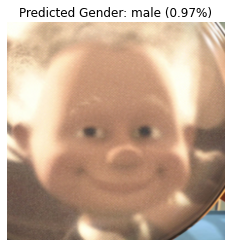

In [ ]:
import torch.nn.functional as F
model.eval()
log_prob = []

with torch.no_grad():
  for x in ['human']:
    for i, (inputs, labels) in enumerate(dataloaders[x]):
      inputs = inputs.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      probability = torch.max(F.softmax(outputs, dim=1)).item()
      log_prob.append(probability)
      path, _ = dataloaders[x].dataset.samples[i]
      fname = path.split('/')[-1]

      for j in range(inputs.size()[0]):
        ax = plt.subplot(1, 1, 1)
        ax.axis('off')

        pred = class_names[preds[j]]
        ax.set_title(f'Predicted Gender: {pred} ({probability:.2f}%)')

        inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean # denormalise image
        inp = np.clip(inp, 0, 1)
        ax.imshow(inp) # has to show otherwise canvas is blank
        plt.savefig(f'{DST_PATH}/{pred}/{fname}')
        plt.clf

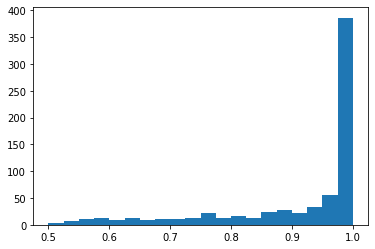

In [ ]:
import matplotlib.pyplot as plt
plt.hist(log_prob, range=(0.5,1), bins=20);

In [ ]:
# Zip to MyDrive
!zip -r /content/drive/MyDrive/machine_learning/Analysis/Disney_3D_Human_Test/cla_predictions_withBG_0.7threshold.zip cla_predictions > /dev/null